###Load necessary libraries and setup plotting

In [1]:
import pandas as pd
import seaborn as sns
import glob
import math
import fiona as fio
from matplotlib.collections import PathCollection, PatchCollection
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Path, PathPatch, Patch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D, art3d

sns.set()
sns.set_style('whitegrid')

###Load in some mock trip data

In [2]:
path =r'/Users/astyler/projects/ChargeCarData/csv'

#haversine function courtesy of https://gist.github.com/rochacbruno/2883505
def haversine(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371000
 
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
 
    return d

def readmanycsv(path):
    allFiles = glob.glob(path + "/illah*.csv")
    dfl = []
    for file_ in allFiles:
        df = pd.read_csv(file_)
        dfl.append(df)
       
    return dfl#pd.concat(dfl, ignore_index=True)

dfl = readmanycsv(path)


In [3]:
#centroid 1 is illahs house, position is (40.4303,-79.9156)
#centroid 2 is EG/morewood, position is (40.4448,-79.9459)
house = (40.4303,-79.9156)
school = (40.4448,-79.9459)

startpos = pd.DataFrame({'lon':[df.Longitude[0] for df in dfl],'lat':[df.Latitude[0] for df  in dfl]})
endpos = pd.DataFrame({'lon':[df.Longitude.iloc[-1] for df in dfl],'lat':[df.Latitude.iloc[-1] for df  in dfl]})

startdistances = [haversine(house,(sp[0],sp[1])) for sp in startpos.values]
enddistances = [haversine(school,(ep[0],ep[1])) for ep in endpos.values]

commutes = [(sd < 150 and ed < 150) for (sd,ed) in zip(startdistances,enddistances)]
cdfl = [df for df,iscommute in zip(dfl,commutes) if iscommute]

#select only commutes
#dfl = cdfl

###Create some helper functions for loading and processing data

In [4]:
def convertcoordinates(m,coords):
    return np.array([m(mx,my) for mx,my in coords])    

def loadshapefile(m,fname):
    shapefile = fio.open(fname)
    lines = []
    polys = []

    for shape in shapefile:
        if shape['geometry']['type']=='Polygon':
            polys.append(shape) 
        if shape['geometry']['type']=='LineString':
            lines.append(shape)

    
    df_polys = pd.DataFrame(shape['properties'] for shape in polys)
    df_polys['path'] = [Path(convertcoordinates(m,shape['geometry']['coordinates'][0])) for shape in polys]
            
    df_lines = pd.DataFrame(shape['properties'] for shape in lines)
    df_lines['path'] = [Path(convertcoordinates(m,shape['geometry']['coordinates'])) for shape in lines]
    return df_polys.append(df_lines)

###Set up the base map, with a view taken from the data area of the path

In [5]:
extra = 0.03
mins=[(min(df.Longitude),min(df.Latitude)) for df in dfl]
maxs=[(max(df.Longitude),max(df.Latitude)) for df in dfl]

ll = map(min,zip(*mins))
ur = map(max,zip(*maxs))

w, h = ur[0] - ll[0], ur[1] - ll[1]

m = Basemap(
    projection='tmerc',
    lon_0=-79.97664,
    lat_0=40.4397,
    ellps = 'WGS84',
    llcrnrlon=ll[0] - extra * w,
    llcrnrlat=ll[1] - extra + 0.01 * h,
    urcrnrlon=ur[0] + extra * w,
    urcrnrlat=ur[1] + extra + 0.01 * h,
    lat_ts=0,
    resolution='c',
    suppress_ticks=True)

for df in dfl: 
    df['x'],df['y'] = convertcoordinates(m,df[['Longitude','Latitude']].values).T
    

###Load in shapefile data

In [9]:
#fname = '/Users/styler/workspace/reference/cmunotebooks/shapefiles/pittsburgh/polygon.shp'
fname = 'shapefiles/pittsburgh/polygon.shp'
df_polys = loadshapefile(m,fname)

In [8]:
#fname = 'C:/Users/styler/workspace/reference/cmunotebooks/shapefiles/pittsburgh/line.shp'
fname = 'shapefiles/pittsburgh/line.shp'
df_lines = loadshapefile(m,fname)

###Draw map and plot all commutes over it

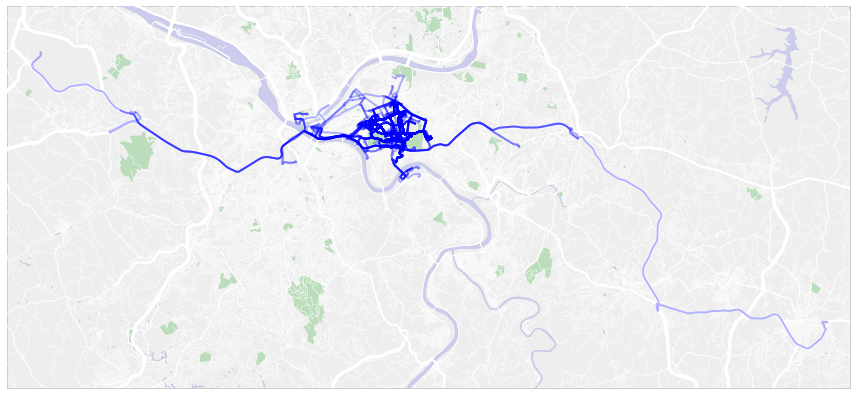

In [10]:
%matplotlib inline
fig     = plt.figure(dpi=600)
ax      = fig.add_subplot(111,)

m.fillcontinents('#EEEEEE',zorder=1)

WATER_FILL = '#CCCCEE'
WATER_EDGE = '#BBBBDD'

PARK_FILL='#BBDDBB'
PARK_EDGE='none'

#BUILDING_FILL='blue'
#BUILDING_EDGE='purple'

HIGHWAY_COLOR = 'white'#'#CCCCCC'
MAJOR_ROAD_COLOR = 'white'#'#CCCCCC'
MINOR_ROAD_COLOR = 'white'#'#EFEFEF'
#water
ax.add_collection(PathCollection(df_polys[(df_polys['waterway'] =='riverbank') | (df_polys['natural'] == 'water')]['path'].values,facecolor=WATER_FILL,edgecolor=WATER_EDGE,zorder=3))

#parks
ax.add_collection(PathCollection(df_polys[(df_polys['leisure'] == 'park') | (df_polys['leisure'] == 'golf_course')]['path'].values, facecolor=PARK_FILL, edgecolor=PARK_EDGE,zorder=4))

#buildings
#ax.add_collection(PathCollection(df_polys[pd.notnull(df_polys['building'])]['path'].values, facecolor=BUILDING_FILL, edgecolor=BUILDING_EDGE, hatch='/////',zorder=4))

#interstates
ax.add_collection(PathCollection(df_lines[(df_lines['highway'] == 'motorway')]['path'].values, facecolor='none', lw=3,edgecolor=HIGHWAY_COLOR, zorder=15))
ax.add_collection(PathCollection(df_lines[(df_lines['highway'] == 'motorway_link')]['path'].values, facecolor='none', lw=1,edgecolor=HIGHWAY_COLOR, zorder=14))

#routes
ax.add_collection(PathCollection(df_lines[(df_lines['highway'] == 'trunk')]['path'].values, facecolor='none', lw=2,edgecolor=MAJOR_ROAD_COLOR, zorder=13))
ax.add_collection(PathCollection(df_lines[(df_lines['highway'] == 'trunk_link')]['path'].values, facecolor='none', lw=1,edgecolor=MAJOR_ROAD_COLOR, zorder=12))

#primary
ax.add_collection(PathCollection(df_lines[(df_lines['highway'] == 'primary')]['path'].values, facecolor='none', lw=1,edgecolor=MAJOR_ROAD_COLOR, zorder=11))
ax.add_collection(PathCollection(df_lines[(df_lines['highway'] == 'primary_link')]['path'].values, facecolor='none', lw=1,edgecolor=MAJOR_ROAD_COLOR, zorder=10))

#secondary
ax.add_collection(PathCollection(df_lines[(df_lines['highway'] == 'secondary')]['path'].values, facecolor='none', lw=1,edgecolor=MINOR_ROAD_COLOR, zorder=9))
ax.add_collection(PathCollection(df_lines[(df_lines['highway'] == 'secondary_link')]['path'].values, facecolor='none', lw=.5,edgecolor=MINOR_ROAD_COLOR, zorder=8))

#minor roads
ax.add_collection(PathCollection(df_lines[(df_lines['highway'] == 'tertiary')]['path'].values, facecolor='none', lw=.5,edgecolor=MINOR_ROAD_COLOR, zorder=7))
ax.add_collection(PathCollection(df_lines[(df_lines['highway'] == 'tertiary_link')]['path'].values, facecolor='none', lw=.5,edgecolor=MINOR_ROAD_COLOR, zorder=6))

ax.add_collection(PathCollection(df_lines[(df_lines['highway'] == 'residential')]['path'].values, facecolor='none', lw=.5,edgecolor=MINOR_ROAD_COLOR, zorder=5))

#plot all complete paths
for df in dfl:
    ax.plot(df.x,df.y,color='blue',lw=2,alpha=.3 ,zorder=99)

#ax.scatter(startpos.x,startpos.y,alpha=0.2,marker=1,zorder=100)
#sns.kdeplot(startpos.x, startpos.y,ax=ax,zorder=100,shade=False,cmap='Purples')
fig.set_size_inches(12,12)
plt.tight_layout()
plt.savefig('foo2.png',dpi=600)
plt.show()